In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [2]:
# data

df = pd.read_csv("https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv").iloc[:, 1:]
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3230,2018-03-31,2.5
3231,2018-04-30,8.9
3232,2018-05-31,13.2
3233,2018-06-30,15.9


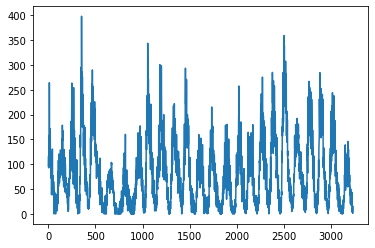

In [3]:
# EDA

plt.plot(df.iloc[:, 1])

In [13]:
time_index = np.array(df['Date'])
data = np.array(df['Monthly Mean Total Sunspot Number'])
batch_size = 32
shuffle_buffer = 1000
ratio = 0.8


split_index = int(len(time_index) * ratio)

train_data = data[:split_index]
train_time = time_index[:split_index]
test_data = data[split_index:]
test_time = time_index[:split_index]

In [20]:
# 轉換資料

def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    """
        將tensor轉換成TensorSliceDataset, 且設定每一次generator資料處理
    """
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(size=window_size+1, shift=1, drop_remainder=True)       # +1因為那個是y
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))  # 一次, return (32, 5, 1), 搭配上面的window!
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # (x, y)
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data



In [21]:
tensor_train_data = tf.expand_dims(train_data, -1)
tensor_test_data = tf.expand_dims(test_data, -1)


train_ds = ts_data_generator(tensor_train_data, 4, batch_size, shuffle_buffer)
test_ds = ts_data_generator(tensor_test_data, 4, batch_size, shuffle_buffer)

In [22]:
for batch_data in train_ds:
    x, y = batch_data  
    print(batch_data)
    break

(<tf.Tensor: shape=(32, 4, 1), dtype=float64, numpy=
array([[[ 94.4],
        [ 70.4],
        [ 89.4],
        [ 82.6]],

       [[106.7],
        [105. ],
        [126.2],
        [103.3]],

       [[  7.5],
        [ 32.3],
        [ 48.9],
        [ 17.9]],

       [[ 21.7],
        [ 20. ],
        [ 18.3],
        [ 61. ]],

       [[189.5],
        [238.3],
        [186.7],
        [185. ]],

       [[163.3],
        [158.3],
        [178.7],
        [146.7]],

       [[ 21.7],
        [  2.4],
        [  9.3],
        [ 13.2]],

       [[ 25.2],
        [ 13.2],
        [ 36.2],
        [ 19.3]],

       [[290. ],
        [230. ],
        [215.3],
        [238.8]],

       [[158.3],
        [178.7],
        [146.7],
        [143.3]],

       [[135.4],
        [136.8],
        [ 79. ],
        [ 83.6]],

       [[ 20.8],
        [ 11.8],
        [  9. ],
        [ 15.7]],

       [[238.8],
        [180.8],
        [188.3],
        [257. ]],

       [[ 43.7],
        [ 52.7],
   

In [23]:
def get_hybrid_model():
    """
        padding: https://stackoverflow.com/questions/52578950/causal-padding-in-keras
    """
    model = keras.Sequential(
        [
         keras.layers.Conv1D(filters=32, kernel_size=5, padding='causal',  activation='relu'),
         keras.layers.GRU(units=64, return_sequences=True),
         keras.layers.GRU(units=64),
         keras.layers.Dense(units=30, activation='relu'),
         keras.layers.Dense(10, activation='relu'),
         keras.layers.Dense(units=1)
        ]
    )
    return model

model = get_hybrid_model()

## Huber loss
- [參考](https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-huber-loss%E5%92%8C-focal-loss-bb757494f85e)
- 對於outlier比較優秀，對比於MSE。

In [24]:

optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_ds, epochs=200, validation_data=test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
81/81 [==============================] - 4s 14ms/step - loss: 80.2280 - mae: 80.7147 - val_loss: 87.7920 - val_mae: 88.2888
Epoch 2/200
81/81 [==============================] - 1s 7ms/step - loss: 79.2405 - mae: 79.7317 - val_loss: 86.4156 - val_mae: 86.9127
Epoch 3/200
81/81 [==============================] - 1s 7ms/step - loss: 76.9860 - mae: 77.4810 - val_loss: 82.3026 - val_mae: 82.8003
Epoch 4/200
81/81 [==============================] - 1s 7ms/step - loss: 68.8111 - mae: 69.3067 - val_loss: 66.9181 - val_mae: 67.4141
Epoch 5/200
81/81 [==============================] - 1s 7ms/step - loss: 49.5398 - mae: 50.0375 - val_loss: 42.7117 - val_mae: 43.2101
Epoch 6/200
81/81 [==============================] - 1s 7ms/step - loss: 29.8479 - mae: 30.3411 - val_loss: 26.6117 - val_mae: 27.1076
Epoch 7/200
81/81 [==============================] - 1s 7ms/step - loss: 24.2668 - mae: 24.7581 - val_loss: 20.6415 - val_mae: 21.1327
Epoch 8/200
81/81 [==============================] - 1

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          18816     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 46,239
Trainable params: 46,239
Non-trainable params: 0
__________________________________________________

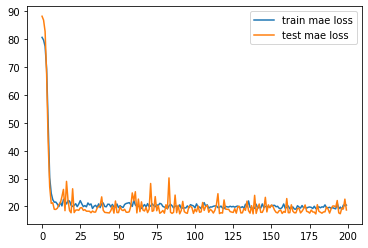

In [26]:
# 畫出損失隨著epoch的圖，確定模型大約的學習狀況。(是否有overfitting/underfitting)


plt.plot(history.history['mae'], label='train mae loss')
plt.plot(history.history['val_mae'], label='test mae loss')
plt.legend()

In [27]:
# 接著，因為模型總歸是要使用的，需要去建立monitor，雖然在訓練時可以看到loss、metrics
# 但是真正在上限時候，我們應該透過定期地檢測目前預測結果，若超過threshold則要去觀察發生什麼事，
# 然後重新訓練新的model


def model_predict(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w:  w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    pred = model.predict(ds)
    return pred

window_size = 4

pred =  model_predict(model, data[..., np.newaxis], window_size)      # (808, 1)
pred = pred[split_index-window_size:-1, 0]                            # 只要test的,  

# error

error = keras.metrics.mean_absolute_error(test_data, pred).numpy()
print(error)

18.646915


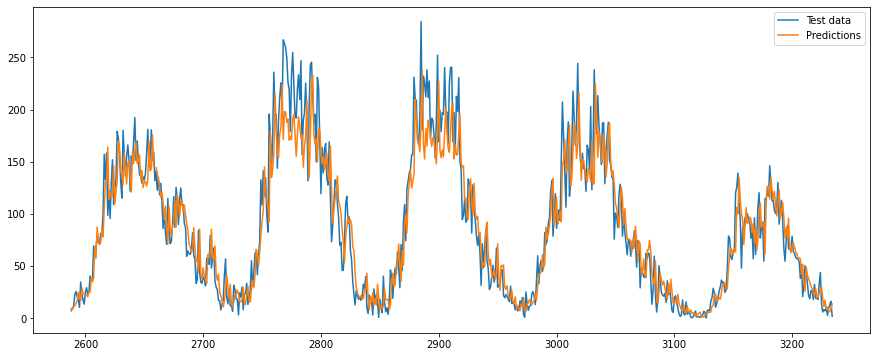

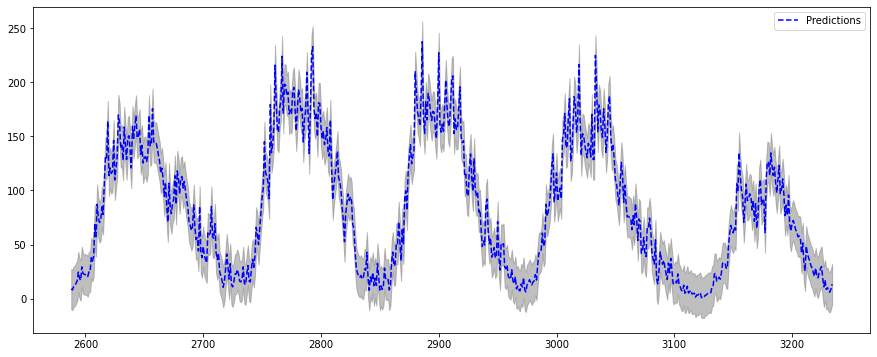

In [35]:
# 視覺化, 看信心程度如何。(其實前面應該先做一個別的。)


# 真實與實際value的對比
plt.figure(figsize=(15, 6))
plt.plot(list(range(split_index, len(data))), test_data, label='Test data')
plt.plot(list(range(split_index, len(data))), pred, label='Predictions')

plt.legend()

# 畫信心程度 搭配 MAE
plt.figure(figsize=(15, 6))
plt.plot(list(range(split_index, len(data))), pred, label='Predictions', linestyle='--', color='b')
plt.fill_between(range(split_index, len(data)), y1=pred+error, y2=pred-error, alpha=0.5, color='gray')
plt.legend()